In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)
table_names = inspector.get_table_names()
print(f"The tables in this database are {table_names}")

column_names = {}
for table in table_names:
    print(f"\nTable: {table}")
    columns = inspector.get_columns(table)
    column_names_x = []
    for c in columns:
        print(c["name"], c["type"])
        column_names_x.append(c["name"])
    column_names.update({table : column_names_x})

print(f"\nColumn names dictionary: {column_names}")

The tables in this database are ['measurement', 'station']

Table: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Table: station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

Column names dictionary: {'measurement': ['id', 'station', 'date', 'prcp', 'tobs'], 'station': ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']}


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Display the row's and columns and data in dictionary format
first_meas = session.query(Measurement).first()
first_meas.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x14cf88dd5c0>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [11]:
# Display the row's and columns and data in dictionary format
first_station = session.query(Station).first()
first_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x22a98681a90>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [12]:
# How many precipitation records are there?
measurement_count = session.query(func.count(Measurement.date))

print(f"There are {measurement_count[0][0]} precipitation records")

There are 19550 precipitation records


In [13]:
# How many Station records are there?
station_count = session.query(func.count(Station.id))

print(f"There are {station_count[0][0]} Station records")

There are 9 Station records


# Exploratory Climate Analysis

The dates range from 2010-01-01 to 2017-08-23

The analysis will be based on data from 2016-08-23 to 2017-08-23


Text(0, 0.5, 'Precipitation\nin')

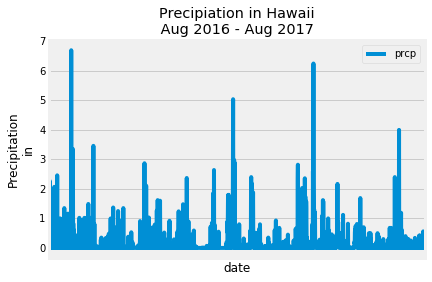

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
start_date_q = session.query(Measurement.date).order_by(Measurement.date).first()[0]
end_date_q = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

end_date = [int(x) for x in end_date_q.split('-')]
end_date = dt.date(end_date[0], end_date[1], end_date[2])

start_date = [int(x) for x in start_date_q.split('-')]
start_date = dt.date(start_date[0], start_date[1], start_date[2])

print(f"The dates range from {start_date} to {end_date}")

analysis_start = end_date - dt.timedelta(days=365)

print(f"\nThe analysis will be based on data from {analysis_start} to {end_date}")

# Perform a query to retrieve the data and precipitation scores
last_year_q = session.query(Measurement).filter(Measurement.date > analysis_start)

# Save the query results as a Pandas DataFrame and set the index to the date column
conn = engine.connect()
last_year_df = pd.read_sql(last_year_q.statement, con=conn)

# Sort the dataframe by date
last_year_df = last_year_df.sort_values("date")
last_year_df = last_year_df.set_index("date")

# Replace "None" precipitation with 0
last_year_df[["prcp"]] = last_year_df[["prcp"]].fillna(value=0)

# Use Pandas Plotting with Matplotlib to plot the data
#plt.plot(last_year_df["tobs"], last_year_df["prcp"] )
ax = last_year_df.plot( y='prcp', use_index=True, xticks = [], title = "Precipiation in Hawaii\n Aug 2016 - Aug 2017 ")
ax.set_ylabel("Precipitation\nin")


In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_df[["prcp"]].describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id))

print(f"There are {station_count[0][0]} Station records")

There are 9 Station records


In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_q = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print("The stations are listed below ordered by number of measurements taken:\n\nName,        Count")
for station in stations_q:
    print(f"{station[0]}, {station[1]}")

active_station = stations_q[0]
print(f"\nThe most active station is {active_station[0]} with {active_station[1]} measurements")

The stations are listed below ordered by number of measurements taken:

Name,        Count
USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511

The most active station is USC00519281 with 2772 measurements


In [56]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#stations_q = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs)).order_by(func.count(Measurement.station).desc()).all()
stations_q = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter_by(station=f"{active_station[0]}").all()

station_max = stations_q[0][1]
station_min = stations_q[0][2]
station_avg = stations_q[0][3]

print(f"The highest temp observed at {active_station[0]} is: {station_max} F\nThe lowest observed is {station_min} F\nThe average observed is {station_avg} F")


The highest temp observed at USC00519281 is: 85.0 F
The lowest observed is 54.0 F
The average observed is 71.66378066378067 F


In [59]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [68]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
result = calc_temps(analysis_start, end_date)
print(f"\nFor all stations, From {analysis_start} to {end_date} the highest recorded temperature was \
{result[0][2]} F\nThe lowest recorded was {result[0][0]} F\nThe average was {round(result[0][1],1)} F")


For all stations, From 2016-08-23 to 2017-08-23 the highest recorded temperature was 87.0 F
The lowest recorded was 53.0 F
The average was 73.1 F


Text(0.5, 1.0, 'Temperature Frequencies for station USC00519281\n2016-08-23 to 2017-08-23')

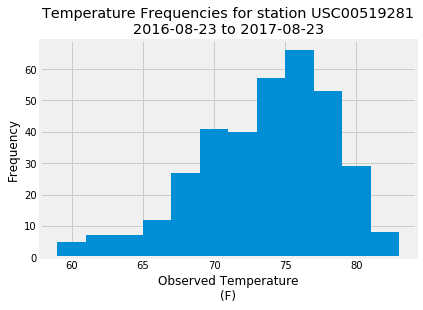

In [110]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
# Plot the results as a histogram with bins=12.

temp_q =session.query(Measurement.tobs, Measurement.station, Measurement.date)\
    .filter(Measurement.date >= analysis_start).filter(Measurement.date <= end_date)\
    .filter_by(station=f"{active_station[0]}")

temp_df = pd.read_sql(temp_q.statement, con=conn)
temp_df.hist(bins=12)
plt.xlabel('Observed Temperature\n(F)')
plt.ylabel('Frequency')
plt.title(f"Temperature Frequencies for station {active_station[0]}\n{analysis_start} to {end_date}")
